Transaction level return prediction: Predict IsReturn for each invoice

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_excel("online_retail_II.xlsx", sheet_name="Year 2010-2011")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [3]:
# Drop rows with missing CustomerID
df = df.dropna(subset=["Customer ID"])

# Convert data types
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Customer ID'] = df['Customer ID'].astype(str)

In [4]:
df.describe()

,Quantity,InvoiceDate,Price
count,406830.000000,406830,406830.000000
mean,12.061276,2011-07-10 16:31:30.127424512,3.460507
min,-80995.000000,2010-12-01 08:26:00,0.000000
25%,2.000000,2011-04-06 15:02:00,1.250000
50%,5.000000,2011-07-31 11:48:00,1.950000
75%,12.000000,2011-10-20 13:06:00,3.750000
max,80995.000000,2011-12-09 12:50:00,38970.000000
std,248.693065,NaN,69.315080


In [5]:
df.isna().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [6]:
df['Invoice'] = df['Invoice'].astype(str)

#separate purchases and returns (returns have invoice with 'C' prefix)
purchases = df[~df['Invoice'].str.startswith('C')].copy()
returns = df[df['Invoice'].str.startswith('C')].copy() #no missing customer ID or Invoice 

In [7]:
df.InvoiceDate.min(), df.InvoiceDate.max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:50:00'))

In [8]:
#returns.tail(10)
#purchases[(purchases['Customer ID'] == "14397.0") & (purchases['StockCode'] == 23144)]

In [9]:
returns.iloc[900:901]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
52422,C540786,22666,RECIPE BOX PANTRY YELLOW DESIGN,-1,2011-01-11 11:42:00,2.95,15194.0,United Kingdom


In [10]:
purchases[(purchases['Customer ID'] == "15194.0") & (purchases['StockCode'] == 22666)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
47380,540413,22666,RECIPE BOX PANTRY YELLOW DESIGN,6,2011-01-07 10:29:00,2.95,15194.0,United Kingdom
105612,545231,22666,RECIPE BOX PANTRY YELLOW DESIGN,6,2011-03-01 10:08:00,2.95,15194.0,United Kingdom
178775,552235,22666,RECIPE BOX PANTRY YELLOW DESIGN,6,2011-05-06 16:17:00,2.95,15194.0,United Kingdom


For one return, the stockcode and customer ID could match with multiple purchases. Match stockcode, customerID, and invoicedate of return should be after invoicedate of purchase

In [11]:
# Add a return flag column
purchases['IsReturn'] = 0

# Sort for easier lookup
purchases.sort_values(by='InvoiceDate', inplace=True)
returns.sort_values(by='InvoiceDate', inplace=True)

# Loop through each return and flag the latest matching purchase before it
for _, ret_row in returns.iterrows():
    cust_id = ret_row['Customer ID']
    stock = ret_row['StockCode']
    ret_date = ret_row['InvoiceDate']
    
    # Find purchases of the same item by the same customer BEFORE the return
    eligible_purchases = purchases[
        (purchases['Customer ID'] == cust_id) &
        (purchases['StockCode'] == stock) &
        (purchases['InvoiceDate'] < ret_date) &
        (purchases['IsReturn'] == 0)  # avoid double-flagging
    ]
    
    if not eligible_purchases.empty:
        # Flag the latest eligible purchase before this return
        idx_to_flag = eligible_purchases.index[-1]
        purchases.at[idx_to_flag, 'IsReturn'] = 1

In [12]:
def bucket_hour(hour):
    if 0 <= hour <= 5:
        return 'Early Morning'
    elif 6 <= hour <= 11:
        return 'Morning'
    elif 12 <= hour <= 17:
        return 'Afternoon'
    elif 18 <= hour <= 21:
        return 'Evening'
    else:
        return 'Late Night'

In [13]:
# Create the hour column first
purchases['InvoiceHour'] = purchases['InvoiceDate'].dt.hour
# Apply bucketing
purchases['TimeOfDay'] = purchases['InvoiceHour'].apply(bucket_hour)
purchases = pd.get_dummies(purchases, columns=['TimeOfDay'], prefix='Time') #no early morning or late night exists

time_cols = [col for col in purchases.columns if col.startswith('Time_')]
purchases[time_cols] = purchases[time_cols].astype(int)

In [14]:
purchases['InvoiceDayOfWeek'] = purchases['InvoiceDate'].dt.dayofweek  # 0 = Monday
purchases['InvoiceMonth'] = purchases['InvoiceDate'].dt.month
purchases['IsWeekend'] = purchases['InvoiceDayOfWeek'].isin([5,6]).astype(int)

In [15]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397925 entries, 0 to 541909
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Invoice           397925 non-null  object        
 1   StockCode         397925 non-null  object        
 2   Description       397925 non-null  object        
 3   Quantity          397925 non-null  int64         
 4   InvoiceDate       397925 non-null  datetime64[ns]
 5   Price             397925 non-null  float64       
 6   Customer ID       397925 non-null  object        
 7   Country           397925 non-null  object        
 8   IsReturn          397925 non-null  int64         
 9   InvoiceHour       397925 non-null  int32         
 10  Time_Afternoon    397925 non-null  int64         
 11  Time_Evening      397925 non-null  int64         
 12  Time_Morning      397925 non-null  int64         
 13  InvoiceDayOfWeek  397925 non-null  int32         
 14  InvoiceMo

In [16]:
free_price_rows = purchases[purchases['Price'] == 0].Price.count() #free products in orders 
print(free_price_rows) #40 rows 

#remove rows where UnitPrice <= 0 because they don’t represent real purchasable items

# Filter out rows that aren't valid purchases
valid_rows = purchases[purchases['Price'] > 0]

40


In [17]:
# Group by StockCode (product ID) - product features
product_features = valid_rows.groupby('StockCode').agg(
    AvgUnitPrice=('Price', 'mean'),
    TotalTimesSold=('Invoice', 'count'),
    TotalQuantitySold=('Quantity', 'sum'),
    ProductReturnCount=('IsReturn', 'sum'),
    ProductReturnRate=('IsReturn', 'mean')  # % of transactions that are returns
).reset_index()

In [18]:
product_features['ProductReturnRate'] = product_features['ProductReturnRate'].round(3)
product_features['AvgUnitPrice'] = product_features['AvgUnitPrice'].round(2)

In [19]:
df1 = valid_rows.merge(product_features, on='StockCode', how='left')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397885 entries, 0 to 397884
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Invoice             397885 non-null  object        
 1   StockCode           397885 non-null  object        
 2   Description         397885 non-null  object        
 3   Quantity            397885 non-null  int64         
 4   InvoiceDate         397885 non-null  datetime64[ns]
 5   Price               397885 non-null  float64       
 6   Customer ID         397885 non-null  object        
 7   Country             397885 non-null  object        
 8   IsReturn            397885 non-null  int64         
 9   InvoiceHour         397885 non-null  int32         
 10  Time_Afternoon      397885 non-null  int64         
 11  Time_Evening        397885 non-null  int64         
 12  Time_Morning        397885 non-null  int64         
 13  InvoiceDayOfWeek    397885 no

In [20]:
# Create total spend per row
purchases['TotalLineValue'] = purchases['Quantity'] * purchases['Price']

# Base customer-level aggregations
customer_features = purchases.groupby('Customer ID').agg(
CustomerOrdersPlaced=('Invoice', 'nunique'),
CustomerTotalItems=('Quantity', 'sum'),
CustomerTotalSpend=('TotalLineValue', 'sum'),
CustomerFirstPurchase=('InvoiceDate', 'min'),
CustomerLastPurchase=('InvoiceDate', 'max'),
CustomerDaysActive=('InvoiceDate', lambda x: x.dt.date.nunique()),
CustomerCountry=('Country', 'first')
).reset_index()

# Derived metrics
customer_features['CustomerAvgBasketSize'] = customer_features['CustomerTotalItems'] / customer_features['CustomerOrdersPlaced']
customer_features['CustomerAvgSpend'] = customer_features['CustomerTotalSpend'] / customer_features['CustomerOrdersPlaced']
customer_features['CustomerLoyaltySpan'] = (customer_features['CustomerLastPurchase'] - customer_features['CustomerFirstPurchase']).dt.days

# Drop unnecessary date columns
customer_features.drop(['CustomerFirstPurchase', 'CustomerLastPurchase'], axis=1, inplace=True)

In [21]:
customer_features.CustomerDaysActive.describe()

count    4339.000000
mean        3.864024
std         5.952745
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max       132.000000
Name: CustomerDaysActive, dtype: float64

<Axes: xlabel='CustomerActivityLevel'>

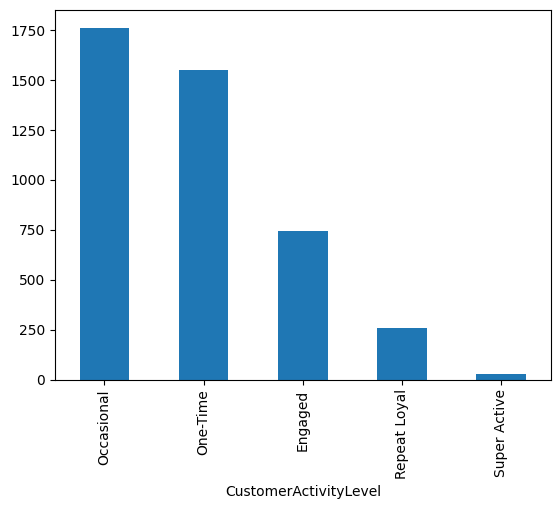

In [22]:
def bucket_days_active(days):
    if days == 1:
        return 'One-Time'
    elif 2 <= days <= 4:
        return 'Occasional'
    elif 5 <= days <= 10:
        return 'Engaged'
    elif 11 <= days <= 30:
        return 'Repeat Loyal'
    else:
        return 'Super Active'

customer_features['CustomerActivityLevel'] = customer_features['CustomerDaysActive'].apply(bucket_days_active)
customer_features['CustomerActivityLevel'].value_counts().plot(kind='bar')

In [23]:
customer_features = pd.get_dummies(customer_features, columns=['CustomerActivityLevel'], prefix='Active')
customer_features_cols = [col for col in customer_features.columns if col.startswith('Active_')]
customer_features[customer_features_cols] = customer_features[customer_features_cols].astype(int)

In [24]:
# Add return behavior from full data (IsReturn = 1 rows included here)
return_stats = purchases.groupby('Customer ID')['IsReturn'].agg(
CustomerNumOfReturns='sum',
CustomerReturnRate='mean'
).reset_index()

# Merge return stats into main features
customer_features = customer_features.merge(return_stats, on='Customer ID', how='left')

# One-hot encode customer country
customer_features = pd.get_dummies(customer_features, columns=['CustomerCountry'], prefix='Country')
customer_country_cols = [col for col in customer_features.columns if col.startswith('Country_')]
customer_features[customer_country_cols] = customer_features[customer_country_cols].astype(int)

# Merge back into main df
df1 = purchases.merge(customer_features, on='Customer ID', how='left')

In [25]:
df1.isna().sum()

Invoice                         0
StockCode                       0
Description                     0
Quantity                        0
InvoiceDate                     0
Price                           0
Customer ID                     0
Country                         0
IsReturn                        0
InvoiceHour                     0
Time_Afternoon                  0
Time_Evening                    0
Time_Morning                    0
InvoiceDayOfWeek                0
InvoiceMonth                    0
IsWeekend                       0
TotalLineValue                  0
CustomerOrdersPlaced            0
CustomerTotalItems              0
CustomerTotalSpend              0
CustomerDaysActive              0
CustomerAvgBasketSize           0
CustomerAvgSpend                0
CustomerLoyaltySpan             0
Active_Engaged                  0
Active_Occasional               0
Active_One-Time                 0
Active_Repeat Loyal             0
Active_Super Active             0
CustomerNumOfR

In [26]:
# Define target variable
y = df1['IsReturn']
# Drop columns that should not be used as features
X = df1.drop(columns=['IsReturn', 'Invoice', 'InvoiceDate', 'StockCode','Description']) 

In [27]:
X.isnull().sum()  # Check missing
X.nunique()       # Check constant/low variance

Quantity                         302
Price                            441
Customer ID                     4339
Country                           37
InvoiceHour                       15
Time_Afternoon                     2
Time_Evening                       2
Time_Morning                       2
InvoiceDayOfWeek                   6
InvoiceMonth                      12
IsWeekend                          2
TotalLineValue                  2940
CustomerOrdersPlaced              59
CustomerTotalItems              1768
CustomerTotalSpend              4255
CustomerDaysActive                51
CustomerAvgBasketSize           2139
CustomerAvgSpend                4264
CustomerLoyaltySpan              374
Active_Engaged                     2
Active_Occasional                  2
Active_One-Time                    2
Active_Repeat Loyal                2
Active_Super Active                2
CustomerNumOfReturns              52
CustomerReturnRate               715
Country_Australia                  2
C

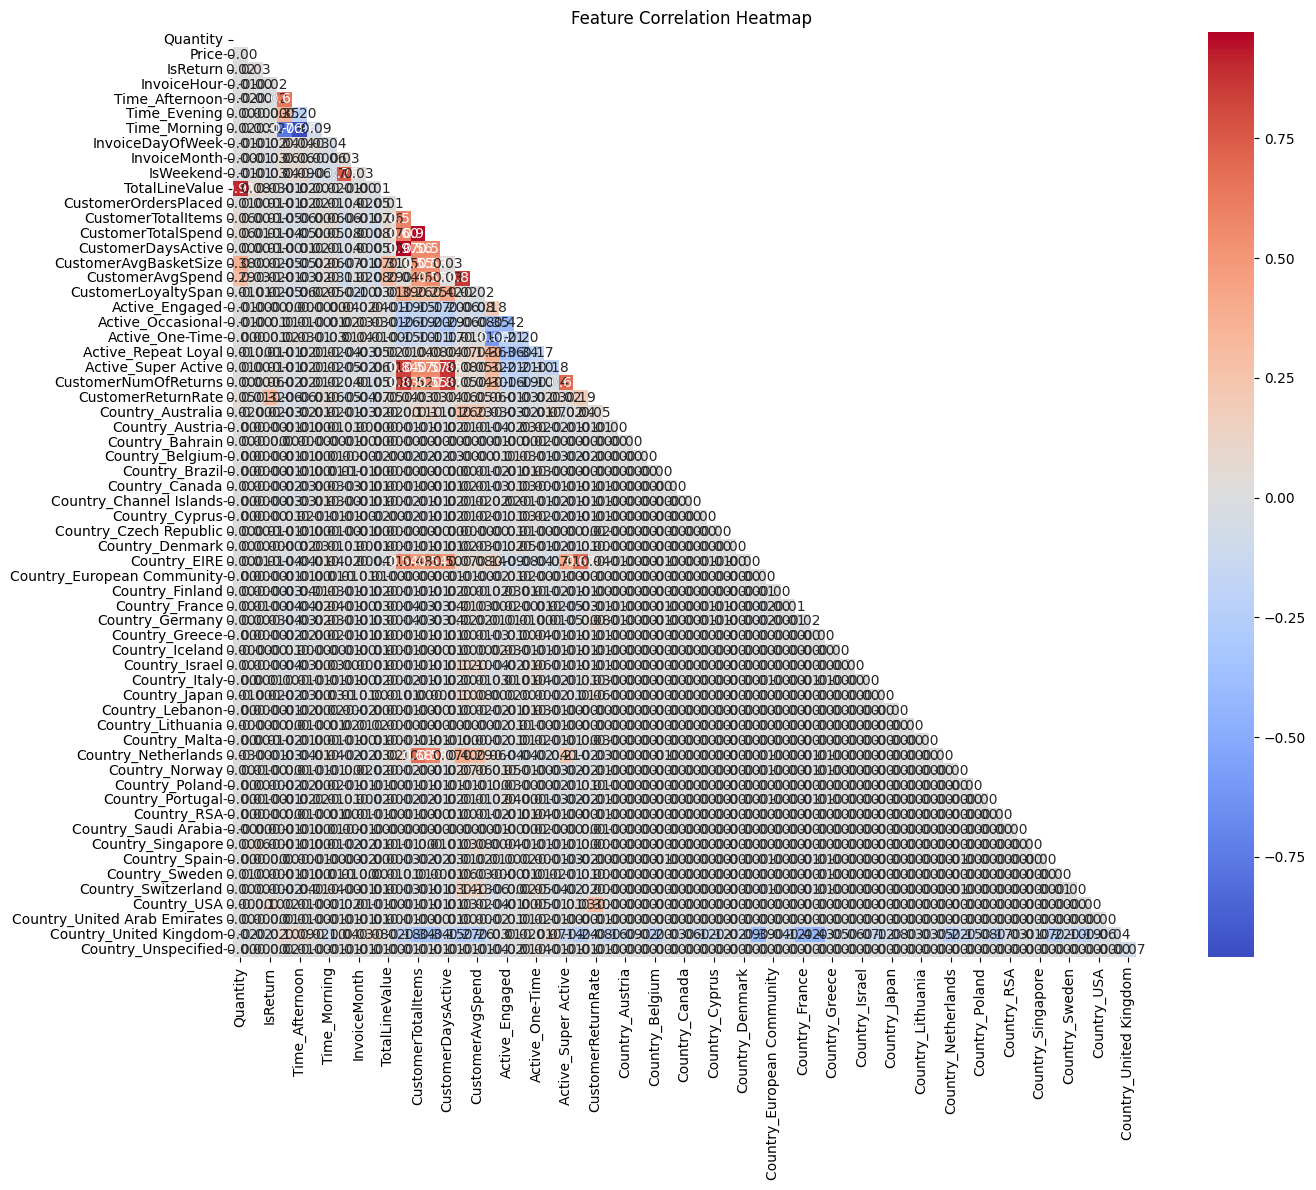

In [28]:
corr = df1.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

In [29]:
high_corr = corr[(corr > 0.8) & (corr < 1.0)]
high_corr_only = high_corr.dropna(how='all').dropna(axis=1, how='all')
high_corr_only

,Quantity,TotalLineValue,CustomerOrdersPlaced,CustomerTotalItems,CustomerTotalSpend,CustomerDaysActive,CustomerAvgBasketSize,CustomerAvgSpend,Active_Super Active,CustomerNumOfReturns
Quantity,NaN,0.908812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TotalLineValue,0.908812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CustomerOrdersPlaced,NaN,NaN,NaN,NaN,NaN,0.971412,NaN,NaN,0.839109,0.830200
CustomerTotalItems,NaN,NaN,NaN,NaN,0.959034,NaN,NaN,NaN,NaN,NaN
CustomerTotalSpend,NaN,NaN,NaN,0.959034,NaN,NaN,NaN,NaN,NaN,NaN
CustomerDaysActive,NaN,NaN,0.971412,NaN,NaN,NaN,NaN,NaN,0.877819,0.870498
CustomerAvgBasketSize,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.86321,NaN,NaN
CustomerAvgSpend,NaN,NaN,NaN,NaN,NaN,NaN,0.86321,NaN,NaN,NaN
Active_Super Active,NaN,NaN,0.839109,NaN,NaN,0.877819,NaN,NaN,NaN,NaN
CustomerNumOfReturns,NaN,NaN,0.830200,NaN,NaN,0.870498,NaN,NaN,NaN,NaN


In [30]:
high_corr_only.columns

Index(['Quantity', 'TotalLineValue', 'CustomerOrdersPlaced',
       'CustomerTotalItems', 'CustomerTotalSpend', 'CustomerDaysActive',
       'CustomerAvgBasketSize', 'CustomerAvgSpend', 'Active_Super Active',
       'CustomerNumOfReturns'],
      dtype='object')

In [31]:
target_corr = corr['IsReturn'].sort_values(ascending=False)
print(target_corr)

IsReturn                        1.000000
CustomerReturnRate              0.318049
Country_USA                     0.095193
CustomerNumOfReturns            0.060262
Price                           0.031080
TotalLineValue                  0.028305
Country_Germany                 0.026349
Quantity                        0.023799
Time_Morning                    0.020672
CustomerAvgBasketSize           0.019919
Country_Japan                   0.018329
CustomerLoyaltySpan             0.017545
CustomerAvgSpend                0.017263
Country_Australia               0.015743
CustomerDaysActive              0.012967
Country_EIRE                    0.012652
CustomerOrdersPlaced            0.011606
Active_Repeat Loyal             0.010711
CustomerTotalSpend              0.010664
Country_Italy                   0.010593
CustomerTotalItems              0.010460
Country_Malta                   0.009868
Active_Super Active             0.007906
Country_Czech Republic          0.005938
Country_Saudi Ar

In [32]:
for col in high_corr_only.columns:
    print(col)
    print(target_corr[col])
    print("\n")

Quantity
0.023799316209625235


TotalLineValue
0.02830468868838923


CustomerOrdersPlaced
0.011606208287580511


CustomerTotalItems
0.010459527250780792


CustomerTotalSpend
0.010664375778713457


CustomerDaysActive
0.01296698388478006


CustomerAvgBasketSize
0.01991925276423639


CustomerAvgSpend
0.017262506224585035


Active_Super Active
0.007906289749407543


CustomerNumOfReturns
0.060262004613044234




In [33]:
df1[df1['IsReturn'] == 1].shape[0]

7421

In [34]:
df1[df1['IsReturn'] == 0].shape[0]

390504

In [35]:
df1[df1['IsReturn'] == 1].shape[0] / df1[df1['IsReturn'] == 0].shape[0] #only 2% of minority class

0.019003646569561387

In [36]:
df1.to_csv('online_retail_cleaned.csv', index=False)